<a href="https://colab.research.google.com/github/mandraa/MachineLearning/blob/main/Job_Sheet_10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama  : Juniar Andra Permana

Kls  : TI3G

NIM  : 2141720214

**PRAKTIKUM 1**

In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label)

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I can safely admit (as an IMDb geek) that \'Phantom Lady\' will never crack into my film noir top twenty. It may not even sneak into the top fifty. But rather than discredit the film for not being as good as so many other classics of the film noir genre, it should be noted that \'Phantom Lady\' has enough strong and lasting images in it to make it a worthwhile viewing. All that is required from the viewer is the ability to get beyond the dreadfully slow beginning.<br /><br />The film doesn\'t get cooking until \'Kansas\' (Ella Raines) sets about trying to prove all but single handedly the innocence of her boss, Scott Anderson (Alan Curtis), who has been convicted of murder. \'Kansas\' is Anderson\'s secretary by day and amateur detective by night. As the novice sleuth she does quite well for herself while working the streets of New York at night. Little by little she starts putting pieces of a murder mystery puzzle together. To be honest, the film belongs to Raines and it is

Buat Teks Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10,  69,   1, ...,   0,   0,   0],
       [ 11,  18,   1, ...,   0,   0,   0],
       [ 15,   4, 154, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I can safely admit (as an IMDb geek) that \'Phantom Lady\' will never crack into my film noir top twenty. It may not even sneak into the top fifty. But rather than discredit the film for not being as good as so many other classics of the film noir genre, it should be noted that \'Phantom Lady\' has enough strong and lasting images in it to make it a worthwhile viewing. All that is required from the viewer is the ability to get beyond the dreadfully slow beginning.<br /><br />The film doesn\'t get cooking until \'Kansas\' (Ella Raines) sets about trying to prove all but single handedly the innocence of her boss, Scott Anderson (Alan Curtis), who has been convicted of murder. \'Kansas\' is Anderson\'s secretary by day and amateur detective by night. As the novice sleuth she does quite well for herself while working the streets of New York at night. Little by little she starts putting pieces of a murder mystery puzzle together. To be honest, the film belongs to Raines and it 

Buat Model

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01442129]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.01442129]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 101ms/step - loss: 0.6302 - accuracy: 0.5790 - val_loss: 0.5340 - val_accuracy: 0.6594
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4195 - accuracy: 0.8008 - val_loss: 0.4141 - val_accuracy: 0.7948
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3585 - accuracy: 0.8416 - val_loss: 0.3612 - val_accuracy: 0.8276
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3272 - accuracy: 0.8579 - val_loss: 0.3342 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3144 - accuracy: 0.8659 - val_loss: 0.3314 - val_accuracy: 0.8448
Epoch 6/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3077 - accuracy: 0.8677 - val_loss: 0.3250 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3010 - accuracy: 0.8707 - val_loss: 0.3466 - val_accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3326 - accuracy: 0.8631
Test Loss: 0.3325995206832886
Test Accuracy: 0.8630800247192383


(0.0, 0.6468087747693062)

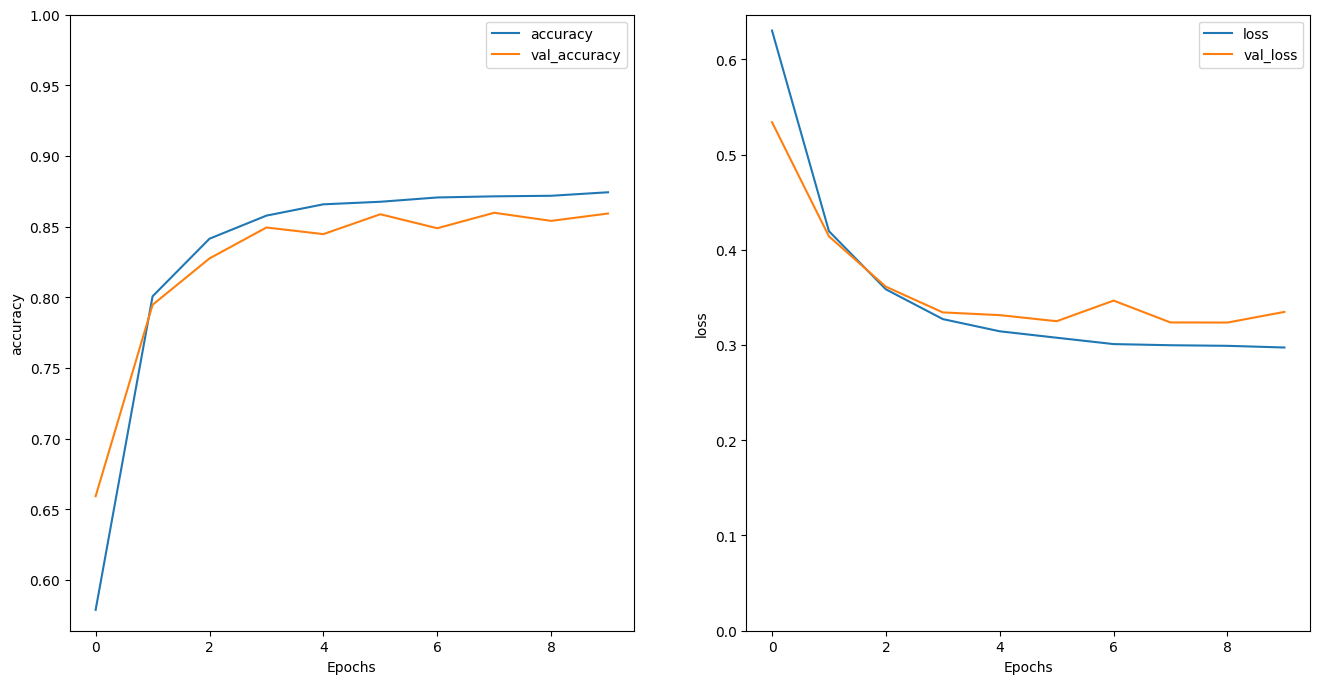

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


Stack two or more LSTM layers

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 154ms/step - loss: 0.6104 - accuracy: 0.6111 - val_loss: 0.4419 - val_accuracy: 0.7812
Epoch 2/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3866 - accuracy: 0.8335 - val_loss: 0.3513 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3396 - accuracy: 0.8563 - val_loss: 0.3297 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3268 - accuracy: 0.8639 - val_loss: 0.3270 - val_accuracy: 0.8474
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3145 - accuracy: 0.8676 - val_loss: 0.3317 - val_accuracy: 0.8422
Epoch 6/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3121 - accuracy: 0.8695 - val_loss: 0.3239 - val_accuracy: 0.8516
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3063 - accuracy: 0.8719 - val_loss: 0.3174 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3212 - accuracy: 0.8502
Test Loss: 0.32116442918777466
Test Accuracy: 0.8501999974250793


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8452591]]


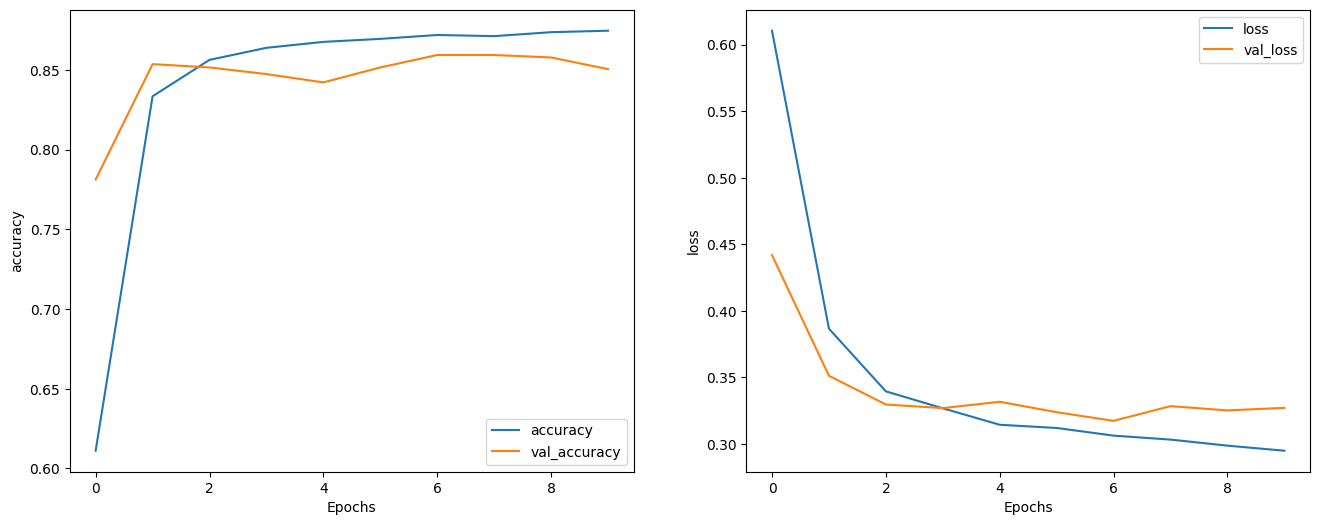

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**PRAKTIKUM 2**

In [27]:
#Import TensorFlow

import tensorflow as tf
import numpy as np
import os
import time

In [28]:
#Download Dataset Shakespeare

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [29]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [31]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


Olah Teks

In [32]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [33]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [34]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [35]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [36]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [37]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [38]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

In [39]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [40]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [41]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [42]:
seq_length = 100

In [43]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [44]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [45]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [46]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [47]:
dataset = sequences.map(split_input_target)

In [48]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [49]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Buat Model

In [50]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [51]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [52]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Uji Model

In [53]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [54]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([59,  2,  0,  3, 54, 11,  4, 16,  8, 54, 65, 38, 41,  1, 15, 30, 55,
        7, 65,  0, 35, 11, 46, 27, 44, 61, 44,  7, 17, 42, 13, 50, 40, 39,
       37, 57, 33, 52,  5, 62, 40,  0, 24, 44, 61, 61, 45, 33, 14, 26, 11,
       44, 32, 37, 29,  8, 60, 16, 59, 51, 27, 26,  6,  6, 31, 18, 26, 36,
        0, 11, 54, 22, 39, 57, 27, 27, 60, 53, 54, 61, 45, 60, 25, 18, 63,
       49, 40, 46,  6, 22, 53, 15,  5, 43,  7, 49,  2, 63,  5, 14])

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'im in the malmsey-butt\nin the next room.\n\nSecond Murderer:\nO excellent devise! make a sop of him.\n\nF'

Next Char Predictions:
 b"t [UNK]!o:$C-ozYb\nBQp,z[UNK]V:gNeve,Dc?kaZXrTm&wa[UNK]KevvfTAM:eSXP-uCtlNM''REMW[UNK]:oIZrNNunovfuLExjag'InB&d,j x&A"


Train Model

In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1896896, shape=(), dtype=float32)


In [61]:
tf.exp(example_batch_mean_loss).numpy()

66.002304

In [62]:
model.compile(optimizer='adam', loss=loss)

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [64]:
EPOCHS=20

In [65]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 57ms/step - loss: 2.7103
Epoch 2/20
172/172 [==============================] - 11s 58ms/step - loss: 1.9804
Epoch 3/20
172/172 [==============================] - 12s 61ms/step - loss: 1.7029
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 1.5423
Epoch 5/20
172/172 [==============================] - 12s 59ms/step - loss: 1.4445
Epoch 6/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3771
Epoch 7/20
172/172 [==============================] - 11s 57ms/step - loss: 1.3248
Epoch 8/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2789
Epoch 9/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2379
Epoch 10/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1966
Epoch 11/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1564
Epoch 12/20
172/172 [==============================] - 13s 60ms/step - loss: 1.1141
E

In [66]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [67]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [68]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
O, that a miscarry aid, I warrant he, for being a king
'Forth anon be done but that your gentle heart,
Throw your throne, please some two days since,
Perfocted parlication. Is he we'lled in the maid,
Since you were dead, he'll pardon him.

DUKE VINCENTIO:
He did it not.

PETRUCHIO:
Confess, we have been in a beward, news are too harm, than
Unloss, pardoning to him. Beny jointy.

RICCAPUM:
Here comes a bracious movery; if
I am no hope to have her. Poor shipping!
Come, another wakened as what we can persure.
But I, present to thee?

AUFIDIUS:
I have done some cabtain counters' grasss,
And bad more muricioning, after dirscern,
Gails for this night instruction.
As he says, if he come to me,
To sit at it with some mildness plented pardon.

JOHN OF GAUNT:
Wilt thou, his mother way his pie-change to have made.

Gaoler:
I pray you, became of my wrongs:
One that I seek to Friar Laughtor, Bianca
Loved the gates of thine eye or
stones,--

SEBASTIAN:
You have made for his title of your shee

In [69]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nGood hour, my friendshire.\n\nDUKE OF YORK:\nTake nothing of a pall,\nLeavy die thy hand in scarsp'd cuckol'd,\nTheir bannet of my daughter's bosom's tyrant:\nCome and not so much in my treasury,\nWhen I am half, I will not follow us;\nAnd I with tears unto thy hands and longer-sparent directions\nacheed. Here in the back of this.\n\nMARCIUS:\nNow, dear Juliet, we must be impatience.\n\nTailor:\nA mind of you the stone with head and love;\nFor whom, I chargement, so much more a soul-river:\nAnd still my braving childer's like and waters, who\nsupersted all thy opposite. Upony that deserved you hence conferenes to Say\nI chy exterp a man with you; from him to draw thee\nFaces again. Did you snow thine well, being smelt!\nWill rest untilour kinsmen are at Ged,\nAnd satisfy children a good duty to command.\n\nRICHARD:\nO, wedness'd, Warwick!'\n\nSICINIUS:\nThe queen met strength and spit at the traitor that I say\n'Twere set my brother judgment; on poison need\nTheir

In [70]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [71]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
O heavens! O wafe with him an art
with't for stir! shall we go frown as true and livers stain the s


**TUGAS**

In [74]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

In [75]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [76]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [77]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 56ms/step - loss: 2.7433


In [78]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.2055
Epoch 1 Batch 50 Loss 2.0941
Epoch 1 Batch 100 Loss 1.9610
Epoch 1 Batch 150 Loss 1.8608

Epoch 1 Loss: 2.0061
Time taken for 1 epoch 13.84 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8513
Epoch 2 Batch 50 Loss 1.7477
Epoch 2 Batch 100 Loss 1.7144
Epoch 2 Batch 150 Loss 1.6725

Epoch 2 Loss: 1.7245
Time taken for 1 epoch 11.59 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6038
Epoch 3 Batch 50 Loss 1.5102
Epoch 3 Batch 100 Loss 1.5588
Epoch 3 Batch 150 Loss 1.5785

Epoch 3 Loss: 1.5599
Time taken for 1 epoch 12.10 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4124
Epoch 4 Batch 50 Loss 1.4363
Epoch 4 Batch 100 Loss 1.4255
Epoch 4 Batch 150 Loss 1.4603

Epoch 4 Loss: 1.4585
Time taken for 1 epoch 11.50 sec
_____________________________________________________________________

**Perbedaan**

Perbedaan utama antara tugas dan praktikum 2 terletak pada train yang digunakan. Praktikum 2 menggunakan train yang lebih umum dan sederhana dengan model.fit, sedangkan kode tuga menggunakan train yang khusus dan kompleks. Dalam pendekatan ini, ada penggunaan metode train_step dalam model turunan yang mengatur train pada tingkat batch. Ini melibatkan perhitungan loss, perhitungan gradien, peningkatan bobot model, dan pemanfaatan tf.metrics.Mean untuk menghitung rata-rata loss selama proses train. Dengan pendekatan ini, terdapat tingkat kontrol yang lebih besar dan fleksibilitas dalam mengatur proses train model.